In [1]:
from scipy.io import loadmat
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import Axes3D
import copy

In [34]:
path= "C:/Users/Charlotte/Dropbox/Bac_informatique/Automne 2020/Analyse geometrique des donnees/Chronic-Liver-Classification/"

with open(path + 'data/02_interim/bmodes_steatosis_assessment_IJCARS.pickle', 'rb') as handle:
    df = pickle.load(handle)

In [2]:
with open('D:/Cours/scattering_features.pickle', 'rb') as handle:
    scatter_dict = pickle.load(handle)
    df_scattering = scatter_dict['df']
    scattering_params = {'J':scatter_dict['J'],
                         'M':scatter_dict['M'],
                         'N':scatter_dict['N']}

In [3]:
#Transforming df_scattering to a numpy array excluding class and id
df_scattering.drop("class", inplace = True, axis=1)
df_scattering.drop("id", inplace=True, axis=1)
df_scattering = df_scattering.to_numpy()

In [8]:
M, N= 434, 636 # ultrasound image dimension

In [42]:
# Reshape the data appropriately
data = df['img'].iloc[0].view(1,M*N)
for i in tqdm(range(1,len(df['img']))):
    data = torch.cat([data,df['img'].iloc[i].view(1,M*N)])

100%|████████████████████████████████████████| 549/549 [01:46<00:00,  5.15it/s]


In [4]:
def create_cumul_var_graph(pca):
    ratio = pca.explained_variance_ratio_
    cumulative = np.cumsum(ratio)
    n_components = np.arange(0, len(cumulative))
    plt.plot(n_components, cumulative)
    plt.title("Cumulative Explained Variance by number of components")
    plt.ylabel("Cumulative Ratio")
    plt.xlabel("Number of components")
    

def create_3D_graph(data_3D, classes, ids):
    fig = plt.figure(figsize=plt.figaspect(2))
    
    #normal vs fatty
    normal = data_3D[classes == 0]
    fatty = data_3D[classes == 1]
    ax1 = fig.add_subplot(211, projection='3d')
    ax1.scatter(normal[:,0], normal[:,1], normal[:,2])
    ax1.scatter(fatty[:,0], fatty[:,1], fatty[:,2])
    ax1.title.set_text("Non Fatty vs Fatty")
    
    #patient variance
    ax2 = fig.add_subplot(212, projection='3d')
    for i in range(5):
        data_i = data_3D[ids == i]
        ax2.scatter(data_i[:,0], data_i[:,1], data_i[:,2])
        data_i2 = data_3D[ids == i+30]
        ax2.scatter(data_i2[:,0], data_i2[:,1], data_i2[:,2])
    
    ax2.title.set_text("Patients Variance")
        
    return fig
    

def create_2D_graph(data_2D, classes, ids, fat_pct):
    fig = plt.figure(figsize=plt.figaspect(3))
    
    #normal vs fatty
    normal = data_2D[classes == 0]
    fatty = data_2D[classes == 1]
    ax1 = fig.add_subplot(311)
    ax1.scatter(normal[:,0], normal[:,1])
    ax1.scatter(fatty[:,0], fatty[:,1])
    ax1.title.set_text("Non Fatty vs Fatty")
    
    #Fat %
    ax2 = fig.add_subplot(312)
    ax2.scatter(data_2D[:,0], data_2D[:,1], c = fat_pct)
    ax2.title.set_text("Fat %")
    
    #patient variance
    ax3 = fig.add_subplot(313)
    for i in range(5):
        data_i = data_2D[ids == i]
        ax3.scatter(data_i[:,0], data_i[:,1])
        
        data_i3 = data_2D[ids == i+30]
        ax3.scatter(data_i3[:,0], data_i3[:,1])
        
    ax2.title.set_text("Patients Variance")
        
    return fig

## Regular Data (No transformation)

In [44]:
pca = PCA(n_components=100)
pca.fit(data)
pca_data = pca.transform(data)

In [ ]:
create_cumul_var_graph(pca)

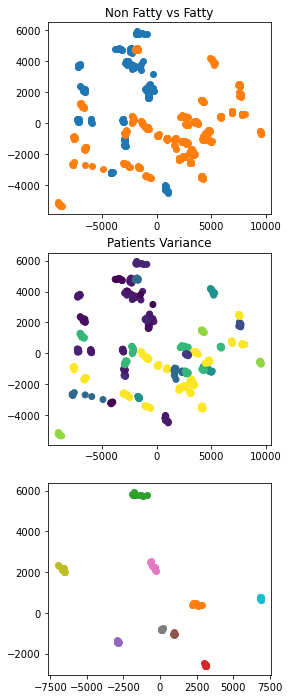

In [45]:
fat_lvl = copy.deepcopy(df['fat'])
fat_lvl[fat_lvl >30] = 30

fig_2d = create_2D_graph(pca_data, df['class'], df['id'], fat_lvl)

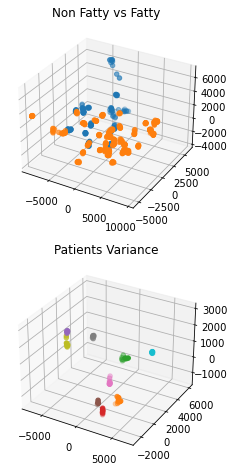

In [21]:
fig_3D = create_3D_graph(pca_data, df['class'], df['id'])

## Scattering Transform

In [29]:
#Scattering
pca_s = PCA(n_components=100)
pca.fit(df_scattering[:,0:100000])
pca_data_s = pca.transform(df_scattering[:,0:100000])

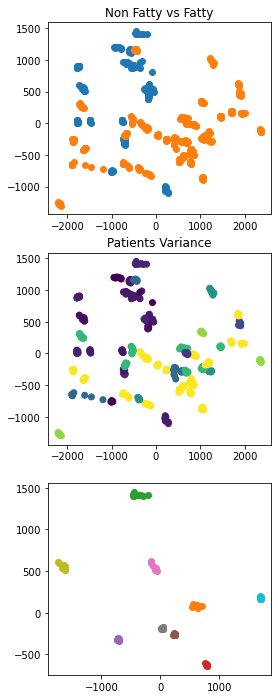

In [30]:
fig_2d = create_2D_graph(pca_data_s, df['class'], df['id'], fat_lvl)

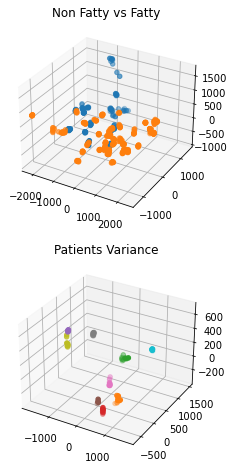

In [20]:
fig_3D = create_3D_graph(pca_data_s, df['class'], df['id'])